__Этот ноутбук получился сильно более сырой. Удалось успеть:__
* Построить свою архитектуру CNN;
* Провести обучение без предобработки изображений, с предобраткой;
* Представить accuracy score для каждой эпохи.  

In [3]:
# Gentleman pack
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Dataset utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from pathlib import Path

# Deep Learning
import torch.nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler

from sklearn.metrics import accuracy_score

# Custom libs
from utils import DATA_DIR, show_imgs, show_ten_imgs

## Базовый вариант датасета изображений

__Так как классы сбалансированы, формируем трэйн тест батчи просто используя SubsetRandomSampler__

In [4]:
transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
        ])

In [5]:
data = datasets.ImageFolder(DATA_DIR, transform=transform)

train_batch_size = 64
test_batch_size = 64

indices = np.arange(len(data.imgs))
train_loader = DataLoader(data, batch_size=train_batch_size, shuffle=False, sampler=SubsetRandomSampler(np.concatenate([indices[:45000], (indices[55000:])]))) 
test_loader = DataLoader(data, batch_size=test_batch_size, shuffle=False, sampler=SubsetRandomSampler(indices[45000:55000]))  # sfuffle is exclusive with sampler, so do this half slice trick

In [4]:
train_datagen, test_datagen = iter(train_loader), iter(test_loader)

train, labels = train_datagen.next()
test, targets = test_datagen.next()

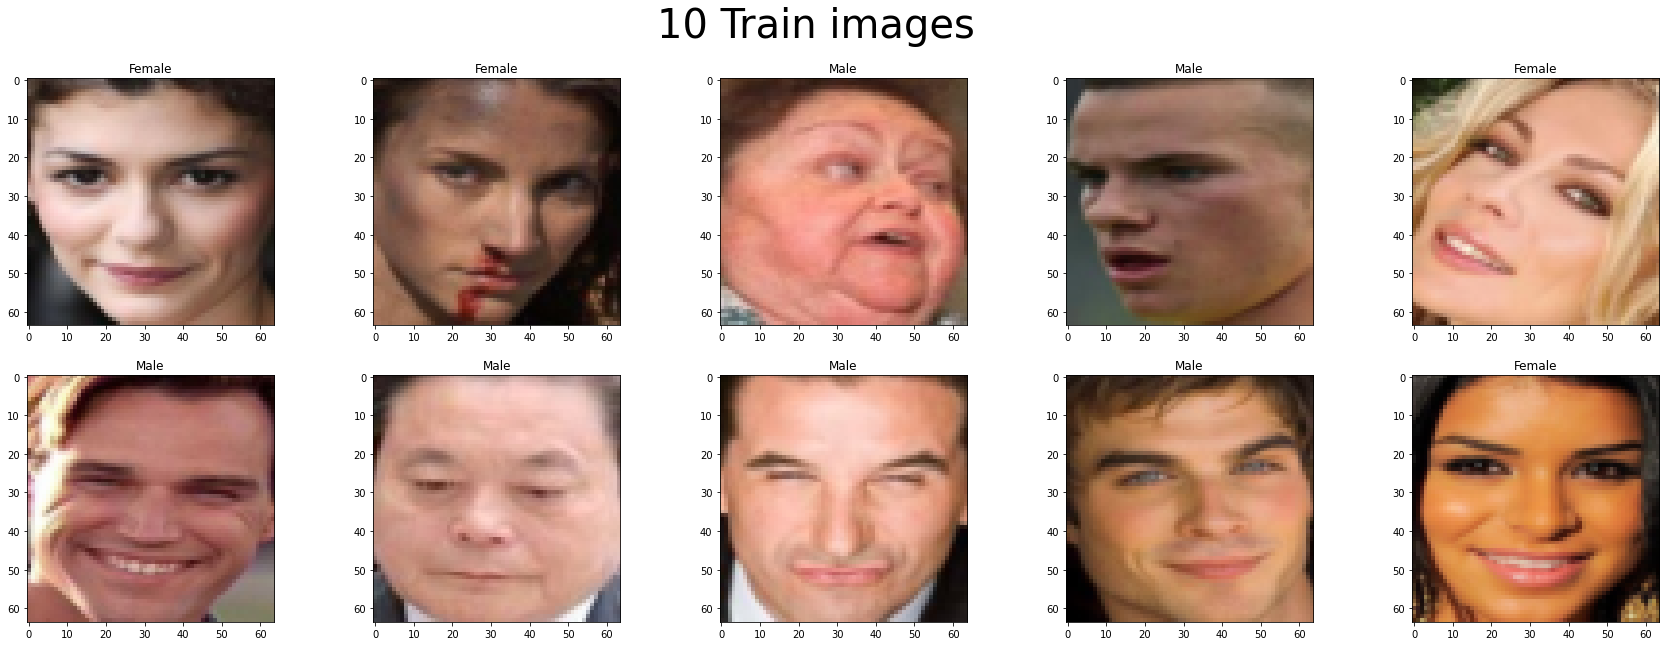

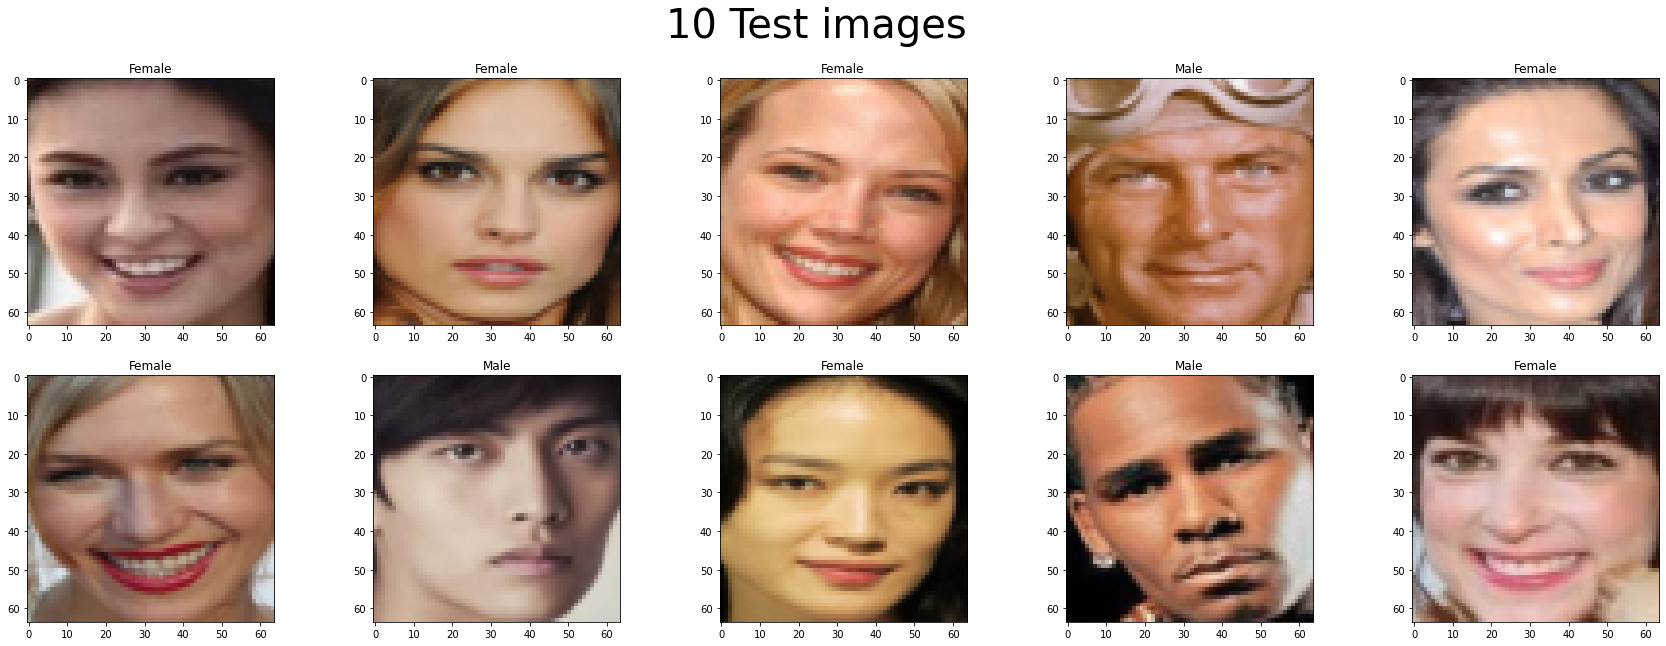

In [5]:
show_ten_imgs(train, labels, title='10 Train images');
show_ten_imgs(test, targets, title='10 Test images');

__Проверка батчей на сбалансированность__

In [6]:
print(f'Male / Female ratio in train batch: {sum(labels.numpy()) / labels.shape[0]}')
print(f'Male / Female ratio in test batch: {sum(targets.numpy()) / targets.shape[0]}')

Male / Female ratio in train batch: 0.53125
Male / Female ratio in test batch: 0.53125


### Информация о  данных

In [7]:
data

Dataset ImageFolder
    Number of datapoints: 100009
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [8]:
print(f"Всего {len(data.imgs)} изображений в датасете")
print(f"Только {len(np.unique(labels))} класса изображений - гендерная классификация")
print(f"Изображения приведены к размеру {train.shape[2]}x{train.shape[3]}")
print(f"Представление батчем тензоров вида {train.numpy().shape} со значениями интенсивности в \
{np.min(train.numpy().reshape(-1))} - {np.max(train.numpy().reshape(-1))} интервале и 3 канала цвета")
print(f"Доля тестовой выборки: 10 %")

Всего 100009 изображений в датасете
Только 2 класса изображений - гендерная классификация
Изображения приведены к размеру 64x64
Представление батчем тензоров вида (64, 3, 64, 64) со значениями интенсивности в 0.0 - 1.0 интервале и 3 канала цвета
Доля тестовой выборки: 10 %


### Custom СNN - своя сеть для опорного результата

In [6]:
class ConvBlock(torch.nn.Module):
    '''CNN convolutional layer constructor'''
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=2),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        return x

In [7]:
class Network(torch.nn.Module):
    '''Full net with Conv and Dense layers and forward pass'''
    def __init__(self):
        super().__init__()
        
        self.conv = torch.nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=256),
#             ConvBlock(in_channels=128, out_channels=256),
#             ConvBlock(in_channels=256, out_channels=512),
        )
                
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256, 32),
            torch.nn.RReLU(0.1, 0.2),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(32, 2),
        )
        

    def forward(self, x):
        x = self.conv(x)
        x = torch.mean(x, dim=3)
        x, _ = torch.max(x, dim=2)
        x = torch.sigmoid(self.fc(x))
        return x

In [8]:
Network()

Network(
  (conv): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (fc): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=256, out_features=32, bias=True)
    (2): RReLU(lower=0.1, upper=0.2)
    (3): BatchNorm1d(32, eps=1e

In [8]:
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=3e-3,  gamma=.1):
    '''Runner of Neural Net training and validation process'''
    
    import time
    from fastprogress import progress_bar, master_bar

    '''default "params"'''
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = Adam(params=model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[epochs * .3, epochs], last_epoch=-1)  # learning rate decay 

    best_epoch = -1
    best_lwlrap = 0.
    bar = master_bar(range(epochs))

    for epoch in bar:
        start_time = time.time()
        
        avg_loss = 0.0
#         train = iter(train_loader)
        for i, batch in enumerate(progress_bar(train_loader, parent=bar)):
            X_batch, y_batch = batch
            optimizer.zero_grad()

            # forward pass
            y_pred = model(X_batch)
            # batch loss
            loss = loss_fn(y_pred, y_batch)
            # backprop
            loss.backward()
            # weights train
            optimizer.step()

            # average batch loss
            avg_loss += loss.item() / len(train_loader)
    
        model.eval()
        # valid_preds = np.zeros((32, 2))  # 2 classes prediction array for 10000 test images
        avg_val_loss = 0.

        for i, (X_batch, y_batch) in enumerate(valid_loader):
            preds = model(X_batch).detach()
            loss = loss_fn(preds, y_batch)

            # accuracy_score(labels.numpy(), np.where(net.forward(images).detach().numpy(), axis=1))
            # valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.numpy()
            preds = preds.numpy()

            avg_val_loss += loss.item() / len(valid_loader)
            
        acc = accuracy_score(np.argmax(preds, axis=1), y_batch.numpy())
        # lwlrap = (score * weight).sum()
        
        scheduler.step()
        
        # print state: epoch, accuracy, average loss every 20 batches
        if (i + 1) % 20 == 20:
            elapsed = time.time() - start_time
            print(f'Epoch {epoch + 1} - accuracy score: {acc} avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}\
            time: {elapsed:.0f}s')
    
        best_epoch = epoch + 1
        
        # if lwlrap > best_lwlrap:
            # best_lwlrap = lwlrap
        torch.save(model.state_dict(), f'weight_best{epoch+3}_affine.pt')

    print('=============================================')
    print('FINISHED Learning')
    print('=============================================')

    return {
        'model': model,
        'best_epoch': best_epoch
        }

In [9]:
'''train on 2 epochы only with weights obtained on Google Colab GPU'''
pretrained_weights = 'weight_best4.pt'  # epoch 5 weights
model = Network()
model.load_state_dict(torch.load(pretrained_weights))

train_loader = DataLoader(data, batch_size=128, shuffle=False,  # batch size 256 is largest possible for RAM with 64x64 images
                          sampler=SubsetRandomSampler(np.concatenate([indices[:5000], (indices[55000:60000])])))
valid_loader = DataLoader(data, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(indices[49000:51000]))

train_model(model, train_loader, test_loader, epochs=2)

In [16]:
valid_loader = DataLoader(data, batch_size=1024, shuffle=False, sampler=SubsetRandomSampler(indices[49000:51000]))  # 1024 batch is hard to process, it is big enough for eval though
test, targets = iter(valid_loader).next()

In [136]:
for epoch in range(7):
    pretrained_weights = f'weight_best{epoch}.pt'  # every epoch evaluation
    model = Network()
    model.load_state_dict(torch.load(pretrained_weights))
    preds = model.forward(test).detach().numpy()
    print(f'Accuracy value is {accuracy_score(np.argmax(preds, axis=1), targets.numpy())} at Epoch {epoch}') 

Accuracy value is 0.8359375 at Epoch 0
Accuracy value is 0.857421875 at Epoch 1
Accuracy value is 0.8486328125 at Epoch 2
Accuracy value is 0.869140625 at Epoch 3
Accuracy value is 0.8505859375 at Epoch 4
Accuracy value is 0.8994140625 at Epoch 5
Accuracy value is 0.9072265625 at Epoch 6


### Обучение с препроцессингом

In [15]:
'''Preprocessing images - making rotations, shears, white balance and colors'''
transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomPerspective(.25),
        transforms.ColorJitter(brightness=.2, contrast=.5, saturation=.4, hue=.1),
        transforms.RandomAffine(degrees=10, shear=7),
        transforms.RandomGrayscale(.3),
        transforms.ToTensor()
        ])
data = datasets.ImageFolder(DATA_DIR, transform=transform)

In [16]:
data

Dataset ImageFolder
    Number of datapoints: 100009
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               RandomPerspective(p=0.5)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.5, 1.5], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
               RandomAffine(degrees=(-10, 10), shear=(-7, 7))
               RandomGrayscale(p=0.3)
               ToTensor()
           )

In [17]:
train_loader = DataLoader(data, batch_size=train_batch_size, shuffle=False, sampler=SubsetRandomSampler(np.concatenate([indices[:45000], (indices[55000:])]))) 
test_loader = DataLoader(data, batch_size=test_batch_size, shuffle=False, sampler=SubsetRandomSampler(indices[45000:55000]))  # sfuffle is exclusive with sampler, so do this half slice trick

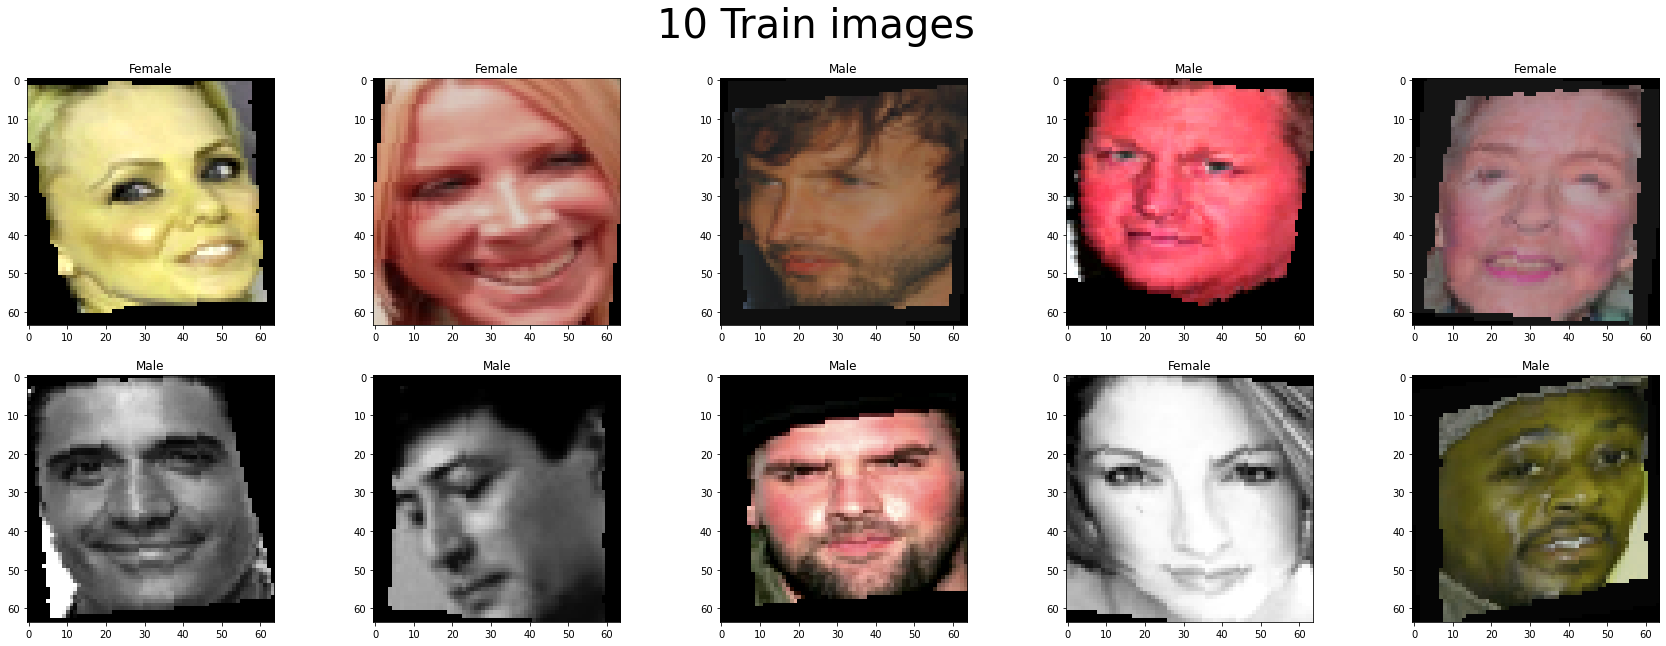

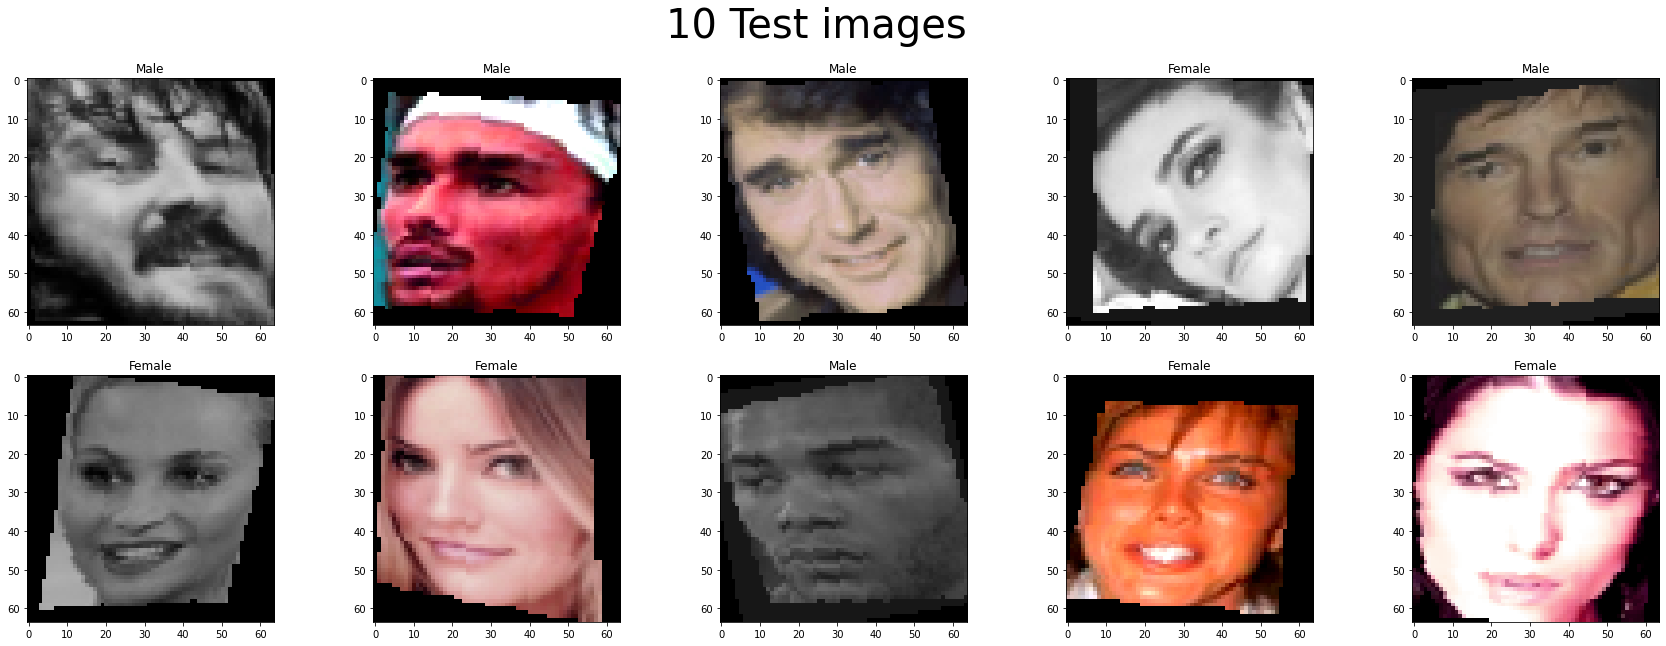

In [18]:
train_datagen, test_datagen = iter(train_loader), iter(test_loader)

train, labels = train_datagen.next()
test, targets = test_datagen.next()

show_ten_imgs(train, labels, title='10 Train images');
show_ten_imgs(test, targets, title='10 Test images');

In [22]:
'''train on 3 epoch with weights obtained earlier'''
pretrained_weights = 'weight_best0_affine.pt'  # epoch 16 weights
model = Network()
model.load_state_dict(torch.load(pretrained_weights))

train_loader = DataLoader(data, batch_size=128, shuffle=False,  # batch size 256 is largest possible for RAM with 64x64 images
                          sampler=SubsetRandomSampler(np.concatenate([indices[:5000], (indices[55000:60000])])))
valid_loader = DataLoader(data, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(indices[49000:51000]))

history = train_model(model, train_loader, test_loader, epochs=1)

FINISHED Learning


In [20]:
for epoch in range(3):
    pretrained_weights = f'weight_best{epoch}_affine.pt'  # every epoch evaluation
    model = Network()
    model.load_state_dict(torch.load(pretrained_weights))
    preds = model.forward(test).detach().numpy()
    print(f'Accuracy value is {accuracy_score(np.argmax(preds, axis=1), targets.numpy())} at Epoch {epoch}') 

Accuracy value is 0.859375 at Epoch 0
Accuracy value is 0.8125 at Epoch 1
Accuracy value is 0.84375 at Epoch 2


__Итого, моя архитектура дает качество accuracy 0.9.__

При этом гипотеза о улучшении предсказаний на валидации при обучении с предобраткой была ошибочной.

__Можно заметить, что accuracy растет от эпохи к эпохе. Модель недообучена, но это при таком датасете занимает время, поэтому оставляю в настоящем виде.__

В свое оправдание могу сказать, что pytorch мне не знаком. Однако вы попросили использовать его.

В плане еще было использование основы VGG, а также добавление PCA из прошлого ноутбука.